In [1]:
import saspy
sas = saspy.SASsession(colorLOG=True)

Using SAS Config named: oda
SAS Connection established. Subprocess id is 9464



In [13]:
# select statement gives outputs in sas
sas.submitLST("""
proc sql; 
    select 
        month format=yymmdd10.,
        sum(actual) as tot_sales,
        sum(predict) as predicted_sales 
    from sashelp.prdsale 
    group by 1 
    order by month ;
quit;
"""
)


Month,tot_sales,predicted_sales
1993-01-01,29813,32385
1993-02-01,29584,29163
1993-03-01,29873,31818
1993-04-01,30581,27429
1993-05-01,31617,30263
1993-06-01,33605,27634
1993-07-01,33578,33220
1993-08-01,31160,28874
1993-09-01,28696,28470
1993-10-01,31355,30262


In [14]:
sas.submitLST("""
proc sql; 
    create table sales as 
    select 
        month format=yymmdd10.,
        sum(actual) as tot_sales,
        sum(predict) as predicted_sales 
    from sashelp.prdsale 
    group by 1 
    order by month ;
quit;
"""
)


In [15]:
sales = sas.sasdata('sales')
sales.columnInfo()

,Member,Num,Variable,Type,Len,Pos,Format,Label
0,WORK.SALES,1.0,MONTH,Num,8.0,0.0,YYMMDD10.,Month
1,WORK.SALES,3.0,predicted_sales,Num,8.0,16.0,NaN,NaN
2,WORK.SALES,2.0,tot_sales,Num,8.0,8.0,NaN,NaN



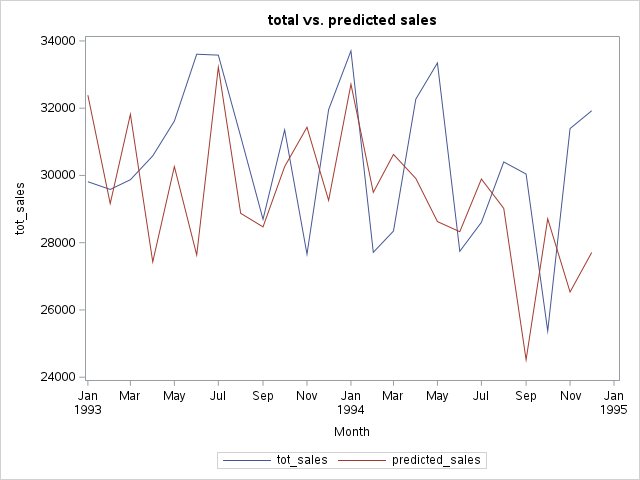

In [16]:
sales.series(y=['tot_sales','predicted_sales'], x='month', title='total vs. predicted sales')

### sql into python pivot routine

In [17]:
sas.submitLOG("""
proc sql;
    create table df as 
    select 
        origin,
        type,
        count(1) as n_cars, 
        avg(msrp) as msrp
    from sashelp.cars
    group by 1, 2
    order by 1, 2;
quit;
"""
)
df = sas.sasdata('df').to_df()
df.columns = df.columns.str.lower()
df.head()

,origin,type,n_cars,msrp
0,Asia,Hybrid,3.0,19920.000000
1,Asia,SUV,25.0,29569.000000
2,Asia,Sedan,94.0,22763.968085
3,Asia,Sports,17.0,32510.647059
4,Asia,Truck,8.0,20383.625000


In [18]:
df.pivot(index='origin', columns='type', values='n_cars')

type,Hybrid,SUV,Sedan,Sports,Truck,Wagon
origin,,,,,,
Asia,3.0,25.0,94.0,17.0,8.0,11.0
Europe,NaN,10.0,78.0,23.0,NaN,12.0
USA,NaN,25.0,90.0,9.0,16.0,7.0


In [19]:
df['msrp'] = df['msrp'].astype(int)
pdf = df.pivot(index='origin', columns='type', values='msrp')
pdf

type,Hybrid,SUV,Sedan,Sports,Truck,Wagon
origin,,,,,,
Asia,19920.0,29569.0,22763.0,32510.0,20383.0,23143.0
Europe,NaN,48346.0,42992.0,71998.0,NaN,37851.0
USA,NaN,34589.0,25638.0,45257.0,27220.0,22345.0


<Axes: xlabel='origin'>

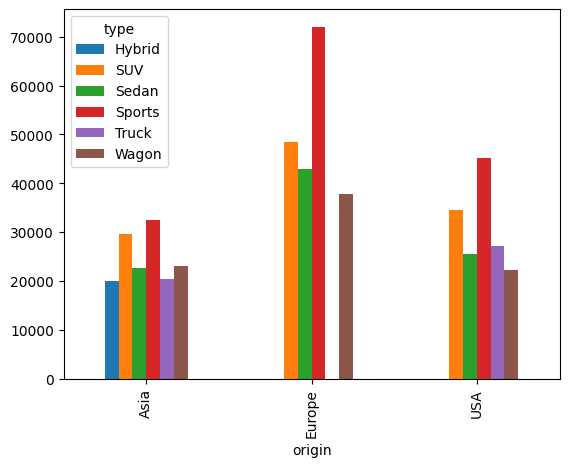

In [24]:
pdf.plot(kind='bar')

### where chaos

In [ ]:
sas.submitLST(f"""
proc sql;
    select count(*)
    from sashelp.cars
    where origin = 'Asia';
""")

""
158


In [32]:
sas.submitLST(f"""
data cars;
    set sashelp.cars;
    where origin = 'Asia';
run;
proc freq data=cars;
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00


In [35]:
sas.submitLST(f"""
data cars;
    set sashelp.cars;
    if origin = 'Asia';
run;
proc freq data=cars;
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00


In [34]:
sas.submitLST(f"""
proc freq data=sashelp.cars (where=(origin='Asia'));
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00
